In [4]:
# Extractive QA - 책에서 문제의 답을 찾는다
# 각 단어가 답의 시작일 확률 계산 : start logits
# 각 단어가 답의 종료일 확률 계산 : end logits
# 가장 확률이 높은 구간 선택 : argmax  

# Extractive QA 시각화
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 모델 로드
MODEL_NAME = "distilbert/distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

In [6]:
question = "What is the capital of France?"
context = "Paris is the capital and largest city of France. The city has a population of 2.1 million."

In [ ]:
# 토크나이제이션
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
tokenizer.decode(inputs['input_ids'][0])
# inputs['input_ids']

tensor([[ 101, 1327, 1110, 1103, 2364, 1104, 1699,  136,  102, 2123, 1110, 1103,
         2364, 1105, 2026, 1331, 1104, 1699,  119, 1109, 1331, 1144,  170, 1416,
         1104,  123,  119,  122, 1550,  119,  102]])

In [13]:
# 토큰리스트
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print(tokens)

['[CLS]', 'What', 'is', 'the', 'capital', 'of', 'France', '?', '[SEP]', 'Paris', 'is', 'the', 'capital', 'and', 'largest', 'city', 'of', 'France', '.', 'The', 'city', 'has', 'a', 'population', 'of', '2', '.', '1', 'million', '.', '[SEP]']


In [11]:
# 예측
with torch.no_grad():
    outputs = model(**inputs)
outputs

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-3.0939, -3.7486, -6.0080, -5.7086, -5.8702, -6.6693, -4.2987, -3.1756,
         -4.0037,  9.6050, -2.3164, -0.6722, -0.0465, -4.4179, -1.2335, -2.8592,
         -4.7219,  0.3473, -2.1641, -0.4413, -2.7191, -5.4559, -4.6687, -4.0404,
         -6.9446, -2.4015, -6.9144, -4.8101, -4.1148, -4.0998, -4.0035]]), end_logits=tensor([[-1.6628, -3.1275, -5.5114, -6.3964, -5.4165, -6.5068, -3.2359, -3.9798,
         -3.7454,  9.3340, -0.6415, -2.9119,  0.9548, -4.1359, -1.7446, -0.0305,
         -4.1837,  3.6946,  1.4507, -3.4107, -3.0052, -5.5297, -5.5761, -3.7925,
         -6.3793, -3.9835, -5.3027, -4.0287, -0.2574, -1.0193, -3.7452]]), hidden_states=None, attentions=None)

In [ ]:
# logit을 확률로 변환
start_probs = torch.softmax(outputs.start_logits, dim=-1)[0].numpy()
end_probs = torch.softmax(outputs.end_logits, dim=-1)[0].numpy()

print(start_probs.shape)
print(end_probs.shape)

# 답변 추출
answer_start = np.argmax(start_probs)
answer_end = np.argmax(end_probs) + 1
answer_tokens = tokens[answer_start:answer_end]

answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f'모델의 답변 : {answer}')
print(f'시작 위치 : {answer_start} 토큰 : {tokens[answer_start]}')
print(f'종료 위치 : {answer_end} 토큰 : {tokens[answer_end-1]}')
print(f'신뢰도    : {start_probs[answer_start] * end_probs[answer_end-1]:.4f}')

(31,)
(31,)
모델의 답변 : Paris
시작 위치 : 9 토큰 : Paris
종료 위치 : 10 토큰 : Paris
신뢰도 : 0.9953


In [33]:
#  상위 5개 후보출력
#  시작위치 상위 5개
top_start = np.argsort(-start_probs)[:5]
for i,index in enumerate(top_start, 1):
    print(f'시작위치 : {i} 토큰 : {tokens[index]} 확률 : {start_probs[index]}')
print("--"*100)
#  종료위치 상위 5개
end_start = np.argsort(-end_probs)[:5]
for i,index in enumerate(end_start, 1):
    print(f'종료위치 : {i} 토큰 : {tokens[index]} 확률 : {end_probs[index]}')

시작위치 : 1 토큰 : Paris 확률 : 0.9996962547302246
시작위치 : 2 토큰 : France 확률 : 9.534518903819844e-05
시작위치 : 3 토큰 : capital 확률 : 6.430930079659447e-05
시작위치 : 4 토큰 : The 확률 : 4.333167817094363e-05
시작위치 : 5 토큰 : the 확률 : 3.4399869036860764e-05
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
종료위치 : 1 토큰 : Paris 확률 : 0.995557963848114
종료위치 : 2 토큰 : France 확률 : 0.0035394439473748207
종료위치 : 3 토큰 : . 확률 : 0.0003753142082132399
종료위치 : 4 토큰 : capital 확률 : 0.00022857259318698198
종료위치 : 5 토큰 : city 확률 : 8.533204527338967e-05


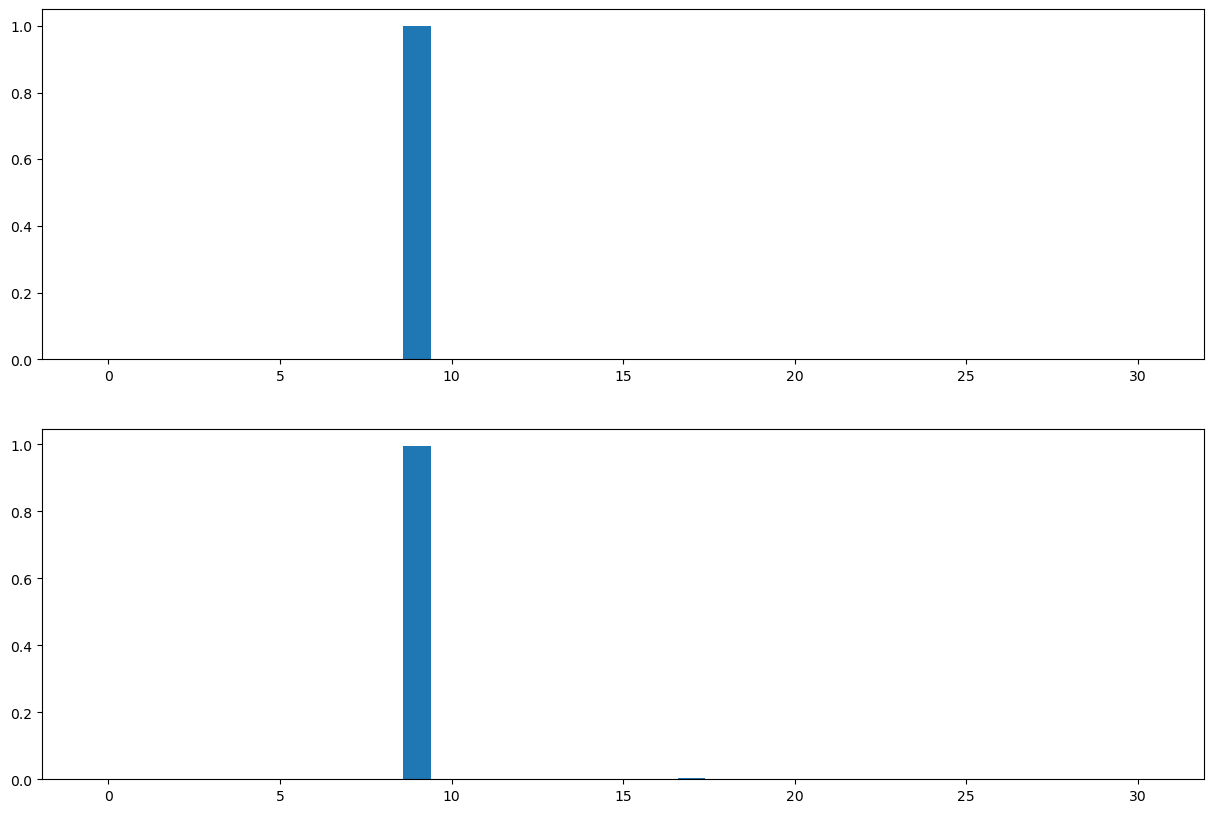

In [37]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,10))
ax1.bar(range(len(tokens)), start_probs)
ax2.bar(range(len(tokens)), end_probs)
plt.show()

In [38]:
# 결론 : 확률이 고르게 분산 -> 답을 못찾은 경우, 특정구간에 집중되면 확신있는 답을 찾음

In [39]:
# offset mapping : 토큰 단위로 찾다보면 단어가 분리되어서 자연스럽지 못하기 때문에 문자위치로 변환하는 과정을 거쳐야 자연스러운 문장이 나온다.   